---

<div class="alert alert-block alert-success">

## Комментарий от наставника

Привет! Спасибо за проект!

Из плюсов отметил:

- Корректный этап предобработки данных
- Корректное выделение пользовательских сессий но основе интервалов между ивентами
- Понравился расчет метрик и признаков пользователя с применением one-hot encoding
- Хороший корреляционный анализ
- Методологически корректная кластрезация пользователей с помощью ML, лайк
- Круто, что есть два варианта кластеризации - по абсолютным и относительным метрикам
- Метрики по группам подсчитаны корректно, они действительно отличаются между группами - признак того, что кластеризация корректная
- Верная проверка статистических гипотез
- Хорошая, аккуратная презентация. Все смысловые блоки есть, слайды содержат выводы и не перегружены информацией

Несовсем верные решения и точки роста (эти замечания критичные, их нужно будет доработать):

- Не использую для визуализации pie-chart: он жутко некрасивый и непонятный при большом количестве действий, да и визуально сравнить доли маленьких действий на нем нельзя. Лучше всего использовать обычную столбчатую диаграмму
    
В целом, очень качественная и хорошая работа, один из лучших проектов!
    


# Анализ приложения "Ненужные вещи"

**Цель** :Аналитику мобильного приложения "Ненужные вещи" необходимо выделить группы пользователей, чтобы в дальнейшем увеличить вовлеченность в приложение. Для этого нужно сформировать типичные портреты пользователей (получить наиболее яркие группы и охарактеризовать их основные свойства на основе метрик активности), и затем с помощью полученных групп выделить наименее активных клиентов, для того чтобы провести в будущем операцию "реанимация" без лишних затрат. 

## Материалы

* [Презентация]  (https://yadi.sk/i/3HuLjKn_nIlxgQ)

## Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:

- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:

- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:

- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## Содержание

[Библиотеки](#biblio)
1. [Общая информация](#information)
2. [Предобработка данных](#preparation)

    - [Корректность наименований колонок](#corec);
    - [Соответствие типов](#type);
    - [Исследование на дубликаты](#dup);
    - [Объединение событий с одиним и тем же действием](#maping).
    
    
3. [Исследовательский анализ данных](#analys)

    - [Определение длительности одной сессии](#look_duration);
    - [Изучение событий](#look_frequency);
    - [Доля пользователей, которые хоть раз совершали событие](#per);
    - [Преобразование категориальных переменных](#category);
    - [Расчёт характеристик пользователя(длительность сессии, число совершенных событий и тип источника)](#info_users);
    - [Рассчёт характеристик пользователя в относительных величинах(среднее число совершенных сессий, среднюю длительность сессии и среднее число каждого типа событий в течении одной сессии)](#info_one_user);
    - [Кластеризация пользователей](#guess).
    

4. [Проверка сегментации пользователей на основе метрик](#segment)

    - [Retention rate](#Retention);
    - [Длительность сеанса](#duration_session);
    - [Частота действий](#frequency);
    - [Конверсия в просмотры контактов](#conversion).
    

5. [Проверка гипотез](#suggests)
    - [Проверка первой гипотезы](#first);
    - [Проверка второй гипотезы](#second).


[Общий вывод](#conclusion)

## Библиотеки <a id='biblio'></a>

In [1]:
#для работы с данными импортируем библиотеку pandas
import pandas as pd
#для работы с временем импортируем библиотеку datetime
import datetime as dt
#для построения графиков будем работать с matplotlib.pyplot
import matplotlib.pyplot as plt
#для построения более сложных и визуально красивее графиков добавим библиотеку seaborn
import seaborn as sns
#импортируем набор методов graph_objects для построения воронки
from plotly import graph_objects as go
#для работы с нормальным распределение и с z-тестом используем библиотеку stats 
from scipy import stats as st
#для применения математических операций(корень)
import math as mth
#для стандартиации признаков используем StandardScaler из sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
#для деления данных на обучающую и вилидационную выборки применяем train_test_split из sklearn.model_selection
from sklearn.model_selection import train_test_split
#для кластеризации пользователей используем метод K-means
from sklearn.cluster import KMeans
#для рассчёта метрик 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
#для построения дендрограммы импортируем dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram, linkage
#для работы над списками и временем импортируем библиотеку numpy
import numpy as np

## 1. Общая информация <a id='information'></a>

Проведём первое знакомство с таблице **mobile_dataset**.

In [2]:
#для прочтения файлов используем метод read_csv()
mobile_dataset=pd.read_csv('/datasets/mobile_dataset.csv')
#Для поверхностного анализа применяем метод info()
mobile_dataset.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', mobile_dataset.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
Количество пропущенных значений:
event.time    0
event.name    0
user.id       0
dtype: int64


In [3]:
#просматриваем данные методом head()
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
#так как нам работать с событиями и воронками,то нам надо точно знать,что в дататсете все названия приведены к одному регистру
#для этого применим метод unique() к столбцу event_name
print('Проверяем уникальные названия в колонке event.name: ', mobile_dataset['event.name'].unique(), sep='\n')

Проверяем уникальные названия в колонке event.name: 
['advert_open' 'tips_show' 'map' 'contacts_show' 'search_4' 'search_5'
 'tips_click' 'photos_show' 'search_1' 'search_2' 'search_3'
 'favorites_add' 'contacts_call' 'search_6' 'search_7' 'show_contacts']


Также изучим данные таблицы **mobile_soures**.

In [5]:
#для прочтения файлов используем метод read_csv()
mobile_sources=pd.read_csv('/datasets/mobile_soures.csv')
#Для поверхностного анализа применяем метод info()
mobile_sources.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', mobile_sources.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
Количество пропущенных значений:
userId    0
source    0
dtype: int64


In [6]:
#просматриваем данные методом head()
mobile_sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [7]:
#скорее всего данные будут разбиты по типу источника, поэтому важно также привести все источники тоже к одному регистру
#для этого применим метод unique() к столбцу source
print('Проверяем уникальные названия в колонке source: ', mobile_sources['source'].unique(), sep='\n')

Проверяем уникальные названия в колонке source: 
['other' 'yandex' 'google']


#### Вывод

На первый взгляд обе таблицы полны и не имеют пропущенных значений. Также можно отметить,что айди пользователей записаны в шестнадцатиричной системе, поэтому тип данных этой колонки-object. Всего есть 3 типа источника, из которых пришел пользователь-other, google и yandex; 16 типов событий,2 из которых характеризиют одно и тоже действие - contacts_show и show_contacts. Из всех колонок только event.time требуется замена типа данных в datetime64[ns]. И во всех названиях колонок разделитель слов нужно привести к нижнему подчеркиванию,чтобы в дальнейшем было удобно работать.

## 2. Предобработка данных<a id='preparation'></a>

### Корректность наименований колонок<a id='corec'></a>

Начало предобработки начнем с замены названий колонок. Для оптимизации работы создадим функцию, которая делает замену '.' на '_'  в названии колонок.

In [8]:
#функция renam будет возвращать новый список названия колонок
#названия, в которых нет разделителей, функция вернёт без изменения
#к названиям, где нужно заменить разделитель на '_', применяем метод replace('.', '_')
def renam(names:list):
    new_columns=[]
    for column in names:
        if '.' not in column:
            new_columns.append(column)
        else:
            new_columns.append(column.replace('.', '_'))
    return new_columns
#применяем функцию renam к списку названия колонок, вытащенных методом .columns
mobile_dataset.columns=renam(mobile_dataset.columns.values)
#проверяем названия столбцов
mobile_dataset.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

In [9]:
#в таблице mobile_sources только одно название нужно заменить, поэтому просто применем метод .rename() к датафрейму
mobile_sources.rename(columns={'userId':'user_id'},inplace=True)
mobile_sources.columns

Index(['user_id', 'source'], dtype='object')

### Соответствие типов<a id='type'></a>

Замена типа данных требуется только для столбца 'event_time' в таблице mobile_dataset. Для изменения типа данных в дату и время достаточно применить pd.to_datetime(time). 

In [10]:
mobile_dataset['event_time' ]=pd.to_datetime(mobile_dataset['event_time' ])
mobile_dataset['event_time' ]

0       2019-10-07 00:00:00.431357
1       2019-10-07 00:00:01.236320
2       2019-10-07 00:00:02.245341
3       2019-10-07 00:00:07.039334
4       2019-10-07 00:00:56.319813
                   ...            
74192   2019-11-03 23:53:29.534986
74193   2019-11-03 23:54:00.407086
74194   2019-11-03 23:56:57.041825
74195   2019-11-03 23:57:06.232189
74196   2019-11-03 23:58:12.532487
Name: event_time, Length: 74197, dtype: datetime64[ns]

### Исследование на дубликаты<a id='dup'></a>

In [11]:
#для проверки данных на дубликаты используем duplicated(keep='first') с атрибутом keep='first'
#keep='first' считает все дубликаты строк кроме первого вхождения
mobile_dataset[mobile_dataset.duplicated(keep='first')]

,event_time,event_name,user_id


In [12]:
mobile_sources[mobile_sources.duplicated(keep='first')]

,user_id,source


Дубликатов не обнаружено не в одной таблице, что очень хорошо.

### Объединение событий с одиним и тем же действием<a id='maping'></a>

События contacts_show и show_contacts характеризуют одно и тоже действие, поэтому объединим их с общим названием show_contacts.

In [13]:
def contacts(event):
    if event =='contacts_show':
        return 'show_contacts'
    else:
        return event
#применяем функцию contacts к столбцу 'event_name'     
mobile_dataset['event_name']=mobile_dataset['event_name'].apply(contacts)
#проверяем наличие уникальных названий в столбце
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

#### Вывод

Все типы данных приведены к нужным, проведена работа над типами событий и названиями колонок, поэтому можно приступить к ананлизу данных.

## 3. Исследовательский анализ данных<a id='analys'></a>

Перед тем как приступить к анализу данных, объеденим таблицы по полю user_id.

In [14]:
#объеденение таблиц проводим методом merge(), данные сохраняем в data
data=mobile_dataset.merge(mobile_sources, on='user_id',how='left')
#создаём колонку 'id', которая будет хранить индекс лога
data=data.reset_index().rename(columns={'index':'id'})
data

,id,event_time,event_name,user_id,source
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...,...
74192,74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74193,74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
74194,74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google
74195,74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


### Определение длительности одной сессии<a id='look_duration'></a>

Для разбияния пользователей на группы необходимо знать длительности сессии. Чтобы определить длительность сессии, надо знать интервал между событиями, начиная с которого мы считаем, что пользователь начал новую сессиию.

1. Для начала данные отсортируем по user_id и event_time, чтобы события каждого пользователя шли последовательно.

In [15]:
data = data.sort_values(['user_id','event_time'])
data.head(10)

,id,event_time,event_name,user_id,source
805,805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
806,806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
809,809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
820,820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
830,830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
831,831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
832,832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
836,836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
839,839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
6541,6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other


2. В колонке ’diff’ для каждого события отдельного пользователя посчитаем разницу между временем посещения страницы и временем посещения предыдущей страницы. Если страница была первой для пользователя, то значение в колонке ’diff’ будет Nan, т. к. нет предыдущего значения.

In [16]:
data['diff'] = data.groupby('user_id')['event_time'].diff(1)
data.head()

,id,event_time,event_name,user_id,source,diff
805,805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,NaT
806,806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:00:45.063550
809,809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:00:34.669580
820,820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:02:15.012972
830,830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:02:10.182041


Таким образом мы определили начальные точки для первых сессий каждого пользователя. 

3. Теперь когда мы знаем интервалы между событиями, мы можем определить границу длительности сессии, как большинство логов, лежащих полевую сторону от данного числа. Визуализирувать данные будем по промежутку времени между событиями в минутах.

In [17]:
#Переведём diff в минуты делением разницы времени на np.timedelta64(1, 'm')
data['diff_min'] = data['diff'] / np.timedelta64(1, 'm')
data.head()

,id,event_time,event_name,user_id,source,diff,diff_min
805,805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,NaT,NaN
806,806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:00:45.063550,0.751059
809,809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:00:34.669580,0.577826
820,820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:02:15.012972,2.250216
830,830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,00:02:10.182041,2.169701


C:\Users\79671\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\79671\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Количество логов')

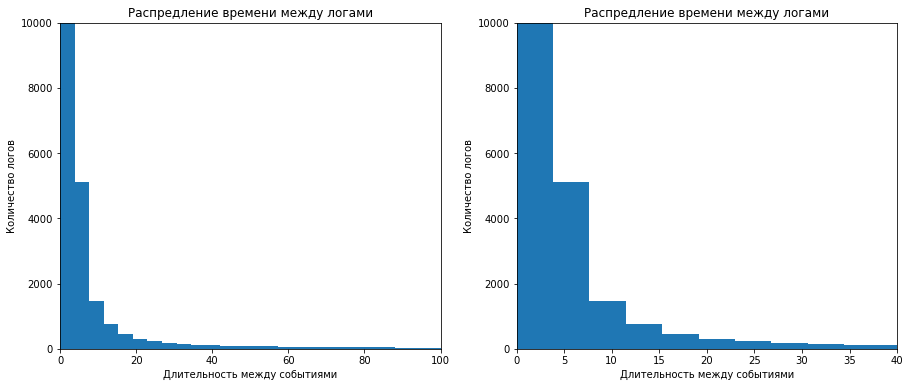

In [18]:
#визуализируем распределение логов по времени с помощью гистограммы
#так как большинство логов точно лежат в районе 10-15 минут, а данных у нас больше 70000,то ограничим ось y значением 10000
#и так как сессия точно не может длиться длиться больше 1,5 часа(интерес у пользователя пропадёт за такой длительный промежуток)
#то ограничим ось x значением 100минут
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.hist(data['diff_min'],bins=10000)
ax1.set_xlim(xmin=0,xmax=100)
ax1.set_ylim(ymin=0,ymax=10000)
ax1.set_title('Распредление времени между логами')
ax1.set_xlabel('Длительность между событиями')
ax1.set_ylabel('Количество логов')
ax2 = fig.add_subplot(122)
ax2.hist(data['diff_min'],bins=10000)
ax2.set_xlim(xmin=0,xmax=40)
ax2.set_ylim(ymin=0,ymax=10000)
ax2.set_title('Распредление времени между логами')
ax2.set_xlabel('Длительность между событиями')
ax2.set_ylabel('Количество логов')

In [19]:
print('Доля логов у которых длительность между событиями меньше 30 минут - ',len(data[data['diff_min']<30])/len(data))

Доля логов у которых длительность между событиями меньше 30 минут -  0.860263892071108


Как мы видим 86% логов имеют длительность между событиями меньше 30 минут, и начиная с этого времени, распределение событий по длительности меняется намного слабже.

4. Следующим этапом сделаем из основного датафрейма ’data’ вспомогательный датафрейм ’data_start_df’. Этот датафрейм будет содержать события, которые будут считаться первыми событиями сессий. К таким событиям относятся все события, которые произошли спустя более чем 30 минут после предыдущего, либо события, которые были первыми для пользователя (Nan в колонке ’diff’). Также создадим во вспомогательном датафрейме колонку ’session_id’, которая будет содержать в себе id первого события сессии. Она пригодится, чтобы корректно отобразить идентификатор сессии, когда будем объединять данные из основного и вспомогательного датафреймов.


In [20]:
data_start_df = data[(data['diff'].isnull()) | (data['diff_min'] > 30)]
data_start_df['session_id'] = data_start_df['id']
data_start_df.head()

<ipython-input-20-d0e4ef73df59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_start_df['session_id'] = data_start_df['id']


,id,event_time,event_name,user_id,source,diff,diff_min,session_id
805,805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,NaT,NaN,805
6541,6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2 days 04:44:13.861346,3164.231022,6541
36412,36412,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,12 days 01:10:07.814984,17350.130250,36412
37556,37556,2019-10-22 11:18:14.635436,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,0 days 15:10:44.584408,910.743073,37556
31632,31632,2019-10-19 21:34:33.849769,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,NaT,NaN,31632


5. С помощью функции merge_asof объединяем между собой данные основного и вспомогательного датафреймов. Для корректной работы функции merge_asof оба датафрейма должны быть отсортированы по ключу, на основе которого будет происходить объединение-это колонка ’id’ у нас.

In [21]:
data = data.sort_values('id')
data_start_df = data_start_df.sort_values('id')
data = pd.merge_asof(data,data_start_df[['id','user_id','session_id']],on='id',by='user_id')
data.head()

,id,event_time,event_name,user_id,source,diff,diff_min,session_id
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,NaT,NaN,0
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,00:00:00.804963,0.013416,0
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,NaT,NaN,2
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,00:00:05.803014,0.096717,0
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,00:00:54.074472,0.901241,2


Таким образом мы получаем в колонке ’session_id’ уникальный идентификатор каждой сессии.

6. Теперь найдем события, которые были первыми в сессиях. Айди таких событий равны идентификаторам сессии. Поэтому просто создадим колонку ’is_first_event_in_session’, в которой сравним между собой значения колонок ’id’ и ’session_id’.



In [22]:
data['is_first_event_in_session'] = (data['id'] == data['session_id'])

7. Предпоследним этапом вычисления длительности сессии, является нахождение времени на определенном событии(странице) сессии. Для этого сначала считаем разницу между предыдущим и следующим событием внутри сессии. Для этого группируем данные по 'session_id’ и методом diff(1) находим разницу. Но так как diff создаёт смещение в 1 строку, то время пребывания на предыдущей странице будет записано в строку следующего события, поэтому нужно сдвинуть значение столбца ’time_on_page’ на одну строку вверх внутри отдельно взятой сессии. Для применим функция shift.

In [23]:
data['time_on_page'] = data.groupby(['session_id'])['event_time'].diff(1)
data['time_on_page'] = data.groupby(['session_id'])['time_on_page'].shift(-1)
data.head()

,id,event_time,event_name,user_id,source,diff,diff_min,session_id,is_first_event_in_session,time_on_page
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,NaT,NaN,0,True,00:00:00.804963
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,00:00:00.804963,0.013416,0,False,00:00:05.803014
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,NaT,NaN,2,True,00:00:54.074472
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,00:00:05.803014,0.096717,0,False,00:01:20.730898
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,00:00:54.074472,0.901241,2,False,00:00:23.673811


А для того чтобы посчитать уже длительность сессии, преобразуем ’time_on_page’ из типа datetime64 в секунды.

In [24]:
data['time_on_page'] = data['time_on_page'] / np.timedelta64(1, 's')
#удаляем лишние столбцы такие как 'diff','diff_min','is_first_event_in_session'
data.drop(['diff','diff_min','is_first_event_in_session'],axis=1,inplace=True)
data

,id,event_time,event_name,user_id,source,session_id,time_on_page
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0.804963
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,5.803014
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,54.074472
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,80.730898
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,23.673811
...,...,...,...,...,...,...,...
74192,74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,30.872100
74193,74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,185.825103
74194,74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google,74194,NaN
74195,74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,66.300298


time_on_page c Nan являются логами последних действий в сессиях.

Также добавим столбцы с датой события, чтобы в будущем выяснить количество выполненных сессий в день, а также проверим максимальную и минимальную дату всех логов.

In [25]:
data['date']=data['event_time'].dt.strftime('%Y-%m-%d')
print('Минимальна дата событий - ', min(data['date']))
print('Максимальна дата событий - ', max(data['date']))
data.head()

Минимальна дата событий -  2019-10-07
Максимальна дата событий -  2019-11-03


,id,event_time,event_name,user_id,source,session_id,time_on_page,date
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0.804963,2019-10-07
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,5.803014,2019-10-07
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,54.074472,2019-10-07
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,80.730898,2019-10-07
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,23.673811,2019-10-07


### Изучение событий<a id='look_frequency'></a>

Изучим частоту событий, чтобы понять можно ли объединить все search в одно событие или нет. Для этого нужно посчитать сколько раз совершался каждый вид события в логах, а затем поделить эти данные на суммарное число всех событий(оно ровно длине таблице данных)

In [26]:
#находим суммарное число всех событий -all_events
all_events=len(data)

In [27]:
#создаем таблицу частот событий, в которой сначала посчитаем число логов с конкретным типом событий
frequencie=(data.groupby('event_name')['id']
             .count()
             .reset_index()
            )
#переименуем столбец 'id' в 'count_event' методом .rename() с указанием inplace = True,чтобы не пересохранять датафрейм
frequencie.rename(columns = {'id':'count_event'}, inplace = True)
#и, наконец, добавляем столбец частоты frequencie
frequencie['frequencie']=frequencie['count_event']/all_events
frequencie.sort_values('frequencie', ascending=False)

,event_name,count_event,frequencie
14,tips_show,40055,0.539847
4,photos_show,10012,0.134938
0,advert_open,6164,0.083076
12,show_contacts,4529,0.061040
3,map,3881,0.052307
5,search_1,3506,0.047253
2,favorites_add,1417,0.019098
9,search_5,1049,0.014138
13,tips_click,814,0.010971
8,search_4,701,0.009448


Получается, что частота у событий search 1,5 и 4 выше частот некоторых других видов событий, и только у search 3,6,2 и 7 частота ниже, причём у событий поисков 3 и 6 частоты оказались близки к частоте contacts_call, поэтому объединять все search в единое действие нельзя. 

### Доля пользователей, которые хоть раз совершали событие<a id='per'></a>

Теперь определим количество пользователей, которые совершали каждое из видов событий, а также посчитаем долю пользователей, которые хоть раз совершали каждый вид.

In [28]:
#сгруппируем данные по событиям и для каждого из них посчитаем число уникальных пользователей
event_users=(data.groupby('event_name', as_index=False)
             .agg({'user_id':'nunique'})
             .sort_values('user_id')
             .rename(columns={'user_id':'count_users'})
            )
#сохраняем бщее число пользователей в переменную total_users
total_users=data['user_id'].nunique()
#поделим стлобец 'count_users' на 'total_users' для получения доли пользователей, которые хоть раз совершали событие
event_users['part']=(event_users['count_users']/total_users).round(3)
#сортируем события по доли sort_values() 
event_users=event_users.sort_values('part',ascending=False) 
event_users

,event_name,count_users,part
14,tips_show,2801,0.652
3,map,1456,0.339
4,photos_show,1095,0.255
12,show_contacts,981,0.229
5,search_1,787,0.183
0,advert_open,751,0.175
9,search_5,663,0.154
8,search_4,474,0.110
2,favorites_add,351,0.082
10,search_6,330,0.077


Как мы видим не одно из событий не совершают все пользователи, причём иерархия событий по частоте не совпадает с иерархией событий по количеству пользователей, а значит некоторые события одни и те же пользователи совершают по несколько раз. Поэтому для кластеризации можно будет использовать и как общее число совершенных событий, так и количество видов событий,которые пользователи совершили за все сессии и за одну сессию, а также нам нужно будет учитывать совершают ли пользователи целевое действие или нет( под целевым понимается "просмотр контактов"-'show_contacts').

### Преобразование категориальных переменных<a id='category'></a>

Последним этапом перед тем, как приступить к рассчёту пользовательских метрик, преобразуем категориальные переменные в бинарные. Для этого применяем функцию pandas.get_dummies(). 

In [29]:
data

,id,event_time,event_name,user_id,source,session_id,time_on_page,date
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0,0.804963,2019-10-07
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,5.803014,2019-10-07
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,54.074472,2019-10-07
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0,80.730898,2019-10-07
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2,23.673811,2019-10-07
...,...,...,...,...,...,...,...,...
74192,74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,30.872100,2019-11-03
74193,74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,185.825103,2019-11-03
74194,74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google,74194,NaN,2019-11-03
74195,74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,74074,66.300298,2019-11-03


In [30]:
data_with_dummies = pd.get_dummies(data, columns=['source', 'event_name'])
data_with_dummies.head()

,id,event_time,user_id,session_id,time_on_page,date,source_google,source_other,source_yandex,event_name_advert_open,...,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_show_contacts,event_name_tips_click,event_name_tips_show
0,0,2019-10-07 00:00:00.431357,020292ab-89bc-4156-9acf-68bc2783f894,0,0.804963,2019-10-07,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2019-10-07 00:00:01.236320,020292ab-89bc-4156-9acf-68bc2783f894,0,5.803014,2019-10-07,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,2019-10-07 00:00:02.245341,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2,54.074472,2019-10-07,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,2019-10-07 00:00:07.039334,020292ab-89bc-4156-9acf-68bc2783f894,0,80.730898,2019-10-07,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,2019-10-07 00:00:56.319813,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2,23.673811,2019-10-07,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Теперь, когда данные готовы, можно приступить к рассчёту пользовательских характеристик, на основе которых мы будем проводить деление людей на группы.

### Расчёт характеристик пользователя(длительность сессии, число совершенных событий и тип источника)<a id='info_users'></a>

Для начала проверим есть ли пользователи, которые приходят из разных источников, а не только всегда из одного.

In [222]:
#считаем сколько раз пользователь приходил из каждого источника,для этого группируем данные методом groupby('user_id') и sum()
source_users=(data_with_dummies.groupby('user_id')
              .agg({'source_google':'min','source_yandex':'min','source_other':'min'})
              .reset_index())
#и отфильтровываем данные по условию, что хотя бы 2 источника не равны одновременно 0, либо 3 сразу
source_users[((source_users['source_google']==0) & (source_users['source_yandex']!=0) & (source_users['source_other']!=0))
            | ((source_users['source_google']!=0) & (source_users['source_yandex']==0) & (source_users['source_other']!=0))
            | ((source_users['source_google']!=0) & (source_users['source_yandex']!=0) & (source_users['source_other']==0))
             | ((source_users['source_google']!=0) & (source_users['source_yandex']!=0) & (source_users['source_other']!=0))]


,user_id,source_google,source_yandex,source_other


Таких пользователей  не найдено, а значит каждого юзера характеризует определенный источник.

Считаем среднюю длительность сессий каждого пользователя, когда было соершенно целевое действие.

In [223]:
#во-первых отделяем айди сессий, в которых совершалось целевое действие
session_with_target=data_with_dummies[data_with_dummies['event_name_show_contacts']!=0]['session_id'].unique()
#затем для каждой сессий с целевым действием каждого пользователя, мы находим длительность сессии
duration_users_target=(data_with_dummies[data_with_dummies['session_id'].isin(session_with_target)]
                       .groupby(['user_id','session_id'])
                       .agg({'time_on_page':'sum'})
                       .reset_index()
                      )
#и на конец мы рассчитываем медиану среди всех длительностей сессий у пользователя,что мы нашли в предыдущем шаге
#берём медиану,чтобы исключить влияние выбросов
median_duration_users_target=duration_users_target.groupby(['user_id']).agg({'time_on_page':'median'}).reset_index()
median_duration_users_target.head()

,user_id,time_on_page
0,00157779-810c-4498-9e05-a1e9e3cedf93,2644.423792
1,00551e79-152e-4441-9cf7-565d7eb04090,279.832272
2,005fbea5-2678-406f-88a6-fbe9787e2268,648.135625
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,0.000000
4,007d031d-5018-4e02-b7ee-72a30609173f,429.028721


Часть пользователей имеют длительность в 0 секунд, а точнее менее 1 секунды, это означает что они за сессию сразу перешли на карточку "просмотр контактов".

In [224]:
#узнаем количество таких пользователей
len(median_duration_users_target[median_duration_users_target['time_on_page']==0])

42

Таких пользователей оказалось 42 человека, что составляет чуть меньше одного процента от всех пользователей приложения. Однако это всё таки группа людей хоть и маленькая,поэтому чтобы отделить данных юзеров от пользователей, что вообще ниразу не совершали данного действия, заменим им длительность на 0.001 секунды, а тем кто вообще не совершал такого действия проставим 0.

In [225]:
def duration_target(user):    
    if user in median_duration_users_target['user_id'].unique():        
        if median_duration_users_target.query('user_id==@user')['time_on_page'].values!=0:
            return median_duration_users_target.query('user_id==@user')['time_on_page'].values[0]
        else:            
            return 0.001
    else:
        return 0
#созданную функцию применяем к  source_users и таким образом создаём датасет, в котором будет указан источник прихода user и 
#средняя длительность сессии, в которой было целевое действие.
source_users['avg_duration_on_target']=source_users['user_id'].apply(duration_target)
source_users.head()

,user_id,source_google,source_yandex,source_other,avg_duration_on_target
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,1,0.000000
1,00157779-810c-4498-9e05-a1e9e3cedf93,0,1,0,2644.423792
2,00463033-5717-4bf1-91b4-09183923b9df,0,1,0,0.000000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,0,0,0.000000
4,00551e79-152e-4441-9cf7-565d7eb04090,0,1,0,279.832272


Также рассчитаем общие характеристики пользователей: средняя длительность сессии,число сессий и число совершенных событий каждого типа.

In [226]:
#Вначале рассчитываем среднюю длительность, аналогично как это делалось для средней длительности целевого теста
duration_users=(data_with_dummies.groupby(['user_id','session_id'])
                       .agg({'time_on_page':'sum'})
                       .reset_index()
                      )
median_duration_users=duration_users.groupby(['user_id']).agg({'session_id':'count','time_on_page':'median'}).reset_index()
median_duration_users.head()

,user_id,session_id,time_on_page
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,676.949512
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,1844.386073
2,00463033-5717-4bf1-91b4-09183923b9df,1,1482.475025
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,956.826653
4,00551e79-152e-4441-9cf7-565d7eb04090,3,3.523496


In [227]:
#для каждого пользователя находим суммарное число совершенных видов действий завсё время
sum_events=(data_with_dummies
            .groupby('user_id')
             .agg({'event_name_search_1':'sum'
                   ,'event_name_search_2':'sum'
                   ,'event_name_search_3':'sum'
                   ,'event_name_search_4':'sum'
                   ,'event_name_search_5':'sum'
                   ,'event_name_search_6':'sum'
                   ,'event_name_search_7':'sum'
                   ,'event_name_show_contacts':'sum'
                   ,'event_name_tips_click':'sum'
                   ,'event_name_tips_show':'sum'
                   ,'event_name_advert_open':'sum'
                   ,'event_name_map':'sum'
                   ,'event_name_photos_show':'sum'
                   ,'event_name_favorites_add':'sum'
                   ,'event_name_contacts_call':'sum'})
            .reset_index()
)
sum_events['all_events']=(sum_events['event_name_search_1']+sum_events['event_name_search_2']
                              +sum_events['event_name_search_3']+sum_events['event_name_search_4']+
                              sum_events['event_name_search_5']+sum_events['event_name_search_6']
                              +sum_events['event_name_search_7']+sum_events['event_name_show_contacts']+
                              sum_events['event_name_tips_click']+sum_events['event_name_tips_show']
                              +sum_events['event_name_advert_open']+sum_events['event_name_map']+
                              sum_events['event_name_photos_show']+sum_events['event_name_favorites_add']
                              +sum_events['event_name_contacts_call']
                             )
sum_events.head()

,user_id,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,event_name_search_7,event_name_show_contacts,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,0,0,0,0,0,0,0,29.0,0,6,0,0,0,35.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,18,0,0,0,0,0,0,11,0,0.0,2,0,33,2,5,71.0
2,00463033-5717-4bf1-91b4-09183923b9df,0,0,0,0,0,0,0,0,0,0.0,0,0,10,0,0,10.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0,0,1,2,6,2,6,0,0,4.0,5,6,0,0,0,32.0
4,00551e79-152e-4441-9cf7-565d7eb04090,1,0,0,0,0,0,0,3,0,0.0,0,0,1,0,3,8.0


И теперь объеденим все найденные характеристики в единое описание действий каждого пользователя.

In [228]:
characteristic_users=(source_users
                      .merge(median_duration_users,on='user_id')
                      .merge(sum_events,on='user_id')
                     )
characteristic_users.head()

,user_id,source_google,source_yandex,source_other,avg_duration_on_target,session_id,time_on_page,event_name_search_1,event_name_search_2,event_name_search_3,...,event_name_search_7,event_name_show_contacts,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,0,1,0.000000,4,676.949512,0,0,0,...,0,0,0,29.0,0,6,0,0,0,35.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,0,1,0,2644.423792,6,1844.386073,18,0,0,...,0,11,0,0.0,2,0,33,2,5,71.0
2,00463033-5717-4bf1-91b4-09183923b9df,0,1,0,0.000000,1,1482.475025,0,0,0,...,0,0,0,0.0,0,0,10,0,0,10.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,0,0,0.000000,6,956.826653,0,0,1,...,6,0,0,4.0,5,6,0,0,0,32.0
4,00551e79-152e-4441-9cf7-565d7eb04090,0,1,0,279.832272,3,3.523496,1,0,0,...,0,3,0,0.0,0,0,1,0,3,8.0


Датафрейм готов и можно приступить к делению пользователей на группы. Однако characteristic_users имеет часть данных в абсолютных величинах, а часть в относительных. Сравнивать абсолютные величины не всегда хорошо, так как куда важнее не масса, а пропорциональные соотношения вещей, поэтому создадим ещё один датафрейм, на основании которого мы также попытаемся найти группы пользователей, только в нем данные будут хранить значения относительных величин.

### Рассчёт характеристик пользователя в относительных величинах(среднее число совершенных сессий, среднюю длительность сессии и среднее число каждого типа событий в течении одной сессии)<a id='info_one_user'></a>

Датафрейм в относительных величинах будет рассчитываться, исходя из усредненного описания действия пользователя в течении одной сессии. Так для начала создадим  sessions_users,которая будет содержать информацию о каждой сессии каждого пользователя: дата сессии, её длительность, тип источника,и количество событий каждого вида.

In [269]:
sessions_users=(data_with_dummies.groupby(['user_id','date','session_id']).agg({'time_on_page':'sum'
                                                                ,'source_google':'min'
                                                                ,'source_other':'min'
                                                                ,'source_yandex':'min'
                                                                ,'event_name_search_1':'sum'
                                                                ,'event_name_search_2':'sum'
                                                                ,'event_name_search_3':'sum'
                                                                ,'event_name_search_4':'sum'
                                                                ,'event_name_search_5':'sum'
                                                                ,'event_name_search_6':'sum'
                                                                ,'event_name_search_7':'sum'
                                                                ,'event_name_show_contacts':'sum'
                                                                ,'event_name_tips_click':'sum'
                                                                ,'event_name_tips_show':'sum'
                                                                ,'event_name_advert_open':'sum'
                                                                ,'event_name_map':'sum'
                                                                ,'event_name_photos_show':'sum'
                                                                ,'event_name_favorites_add':'sum'
                                                                ,'event_name_contacts_call':'sum'})
                .reset_index()
               )
sessions_users['all_events']=(sessions_users['event_name_search_1']+sessions_users['event_name_search_2']
                              +sessions_users['event_name_search_3']+sessions_users['event_name_search_4']+
                              sessions_users['event_name_search_5']+sessions_users['event_name_search_6']
                              +sessions_users['event_name_search_7']+sessions_users['event_name_show_contacts']+
                              sessions_users['event_name_tips_click']+sessions_users['event_name_tips_show']
                              +sessions_users['event_name_advert_open']+sessions_users['event_name_map']+
                              sessions_users['event_name_photos_show']+sessions_users['event_name_favorites_add']
                              +sessions_users['event_name_contacts_call']
                             )
sessions_users.head()

,user_id,date,session_id,time_on_page,source_google,source_other,source_yandex,event_name_search_1,event_name_search_2,event_name_search_3,...,event_name_search_7,event_name_show_contacts,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,805,595.727258,0,1,0,0,0,0,...,0,0,0,9,0,0,0,0,0,9
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,6541,507.385985,0,1,0,0,0,0,...,0,0,0,2,0,2,0,0,0,4
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,36412,899.272096,0,1,0,0,0,0,...,0,0,0,12,0,2,0,0,0,14
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,37556,758.171767,0,1,0,0,0,0,...,0,0,0,6,0,2,0,0,0,8
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,31632,1520.787329,0,0,1,4,0,0,...,0,0,0,0,0,0,5,0,0,9


Затем рассчитываем сколько сессий в день всреднем приходится для конкретного человека. Для этого считаем количество сессий, совершенных юзером в течение дня, и усредням их по пользователю.

In [270]:
session_dates=(sessions_users
              .groupby(['user_id','date'])
              .agg({'session_id':'count'})
              .reset_index())
session_date=session_dates.groupby(['user_id']).agg({'session_id':'mean'}).reset_index().rename(columns={'session_id':'mean_session_in_date'})
session_date.head()

,user_id,mean_session_in_date
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.000000
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.000000
2,00463033-5717-4bf1-91b4-09183923b9df,1.000000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1.166667
4,00551e79-152e-4441-9cf7-565d7eb04090,1.000000


Следующими относительными характеристиками будут является среднее число видов событий для каждого пользователя в течении одной сессии, а также средняя длительность и источник.

In [271]:
avg_events_in_session=(sessions_users
              .groupby(['user_id'])
              .agg({'time_on_page':'median'
                    ,'source_google':'median'
                    ,'source_other':'median'
                     ,'source_yandex':'median'
                     ,'event_name_search_1':'median'
                     ,'event_name_search_2':'median'
                     ,'event_name_search_3':'median'
                     ,'event_name_search_4':'median'
                     ,'event_name_search_5':'median'
                     ,'event_name_search_6':'median'
                        ,'event_name_search_7':'median'
                     ,'event_name_show_contacts':'median'
                     ,'event_name_tips_click':'median'
                    ,'event_name_tips_show':'median'
                     ,'event_name_advert_open':'median'
                     ,'event_name_map':'median'
                     ,'event_name_photos_show':'median'
                     ,'event_name_favorites_add':'median'
                   ,'event_name_contacts_call':'median'
                   ,'all_events':'median'})
              .reset_index())
avg_events_in_session.head()

,user_id,time_on_page,source_google,source_other,source_yandex,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,...,event_name_search_7,event_name_show_contacts,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,676.949512,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.5,0.0,2.0,0.0,0.0,0.0,8.5
1,00157779-810c-4498-9e05-a1e9e3cedf93,1844.386073,0,0,1,4.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,6.0,0.0,0.0,11.5
2,00463033-5717-4bf1-91b4-09183923b9df,1482.475025,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,279.031780,1,0,0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0
4,00551e79-152e-4441-9cf7-565d7eb04090,3.523496,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


И аналогично датафрейму характеристик в абсолютных величинах, мы собираем все относительные характеристики юзеров в один датафрейм под названием characteristic_users_new

In [272]:
characteristic_users_new=(avg_events_in_session
                      .merge(session_date,on='user_id')
                          .merge(source_users[['user_id','avg_duration_on_target']],on='user_id')
                                           )
characteristic_users_new.head()

,user_id,time_on_page,source_google,source_other,source_yandex,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,...,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events,mean_session_in_date,avg_duration_on_target
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,676.949512,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.5,0.0,2.0,0.0,0.0,0.0,8.5,1.000000,0.000000
1,00157779-810c-4498-9e05-a1e9e3cedf93,1844.386073,0,0,1,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,11.5,1.000000,2644.423792
2,00463033-5717-4bf1-91b4-09183923b9df,1482.475025,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,10.0,1.000000,0.000000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,279.031780,1,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.166667,0.000000
4,00551e79-152e-4441-9cf7-565d7eb04090,3.523496,0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.000000,279.832272


### Кластеризация пользователей<a id='guess'></a>

Перед тем, как приступить к кластеризации при помощи методов машинного обучения, проверим бональное деление пользователей на группы по типу источника.

-  **Проверка деления пользователей на группы по типу источника**

Проверим деление пользователей на группы по типу источника первой метрикой- retention rate. 

In [266]:
#ранее мы получали таблицу сессий юзеров , в которой указаны источники сессий,их длительность и дата
#Сгруппируем данные по столбцу 'user_id' методом groupby().
#Для каждого клиента получим дату первого посещения— ['date'].min()
first_visits_date = sessions_users.merge(mobile_sources,on='user_id').groupby('user_id')['date'].min()
#Чтобы в датафрейме не было двух столбцов с одинаковыми названиями, изменим имя на first_visits_date, обратившись к name Series.
first_visits_date.name = 'first_visits_date'
#Методом join() объединим датафрейм sessions_users и Series first_visits_date по столбцу 'user_id'
cogort= sessions_users_.join(first_visits_date,on='user_id')
#Выделим из столбцов first_visits_date и 'session_date' недели.Вызовем astype(): преобразуем столбцы к типу 'datetime64[w]'. 
cogort['first_visits_week']=cogort['first_visits_date'].astype('datetime64[W]')
cogort['visits_week'] = cogort['date'].astype('datetime64[W]')
cogort['cohort_lifetime'] = (
    (cogort['visits_week'] - cogort['first_visits_week'])
    /np.timedelta64(1,'W')
).round().astype('int')

Когортой делаем столбец источников. Рассчитаем количество уникальных посетителей по каждой неделе в зависимости от источника и времени жизни. Далее расчитываем коэффициент удержания за счет отношения числа пользователей к общему числу(когда 0 неделя жизни), а после убираем первый столбец, собираем сводную таблицу и создаём тепловую карту.

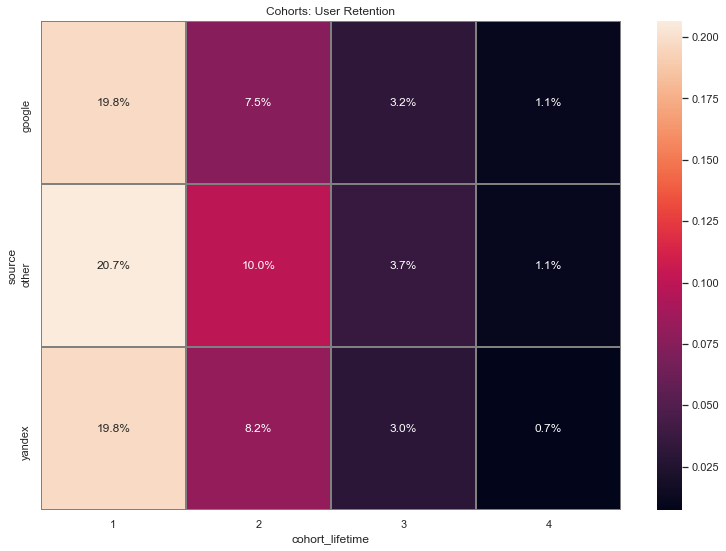

In [267]:
#сделаем аналогичные рассчеты с RR, только теперь когорты будут-источники 
cohorts_for_source=cogort.groupby(['source','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
users_count_for_source=cohorts_for_source[cohorts_for_source['cohort_lifetime']==0][['source', 'user_id']]
users_count_for_source=users_count_for_source.rename(columns={'user_id':'cohort_users'})
cohorts_for_source=cohorts_for_source.merge(users_count_for_source, on='source')
cohorts_for_source['retention']=cohorts_for_source['user_id']/cohorts_for_source['cohort_users']
retention_pivot=cohorts_for_source[cohorts_for_source['cohort_lifetime'] !=0].pivot_table(index='source'
                                                                                          ,columns='cohort_lifetime'
                                                                                          ,values='retention'
                                                                                          ,aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Первая метрика и мы уже не видим отличия между группам с источниками google и yandex, следовательно не имеет смысла делать группы по источнику, поэтому для кластеризации тип источника мы не будем учитывать

- **Матрица корреляции**

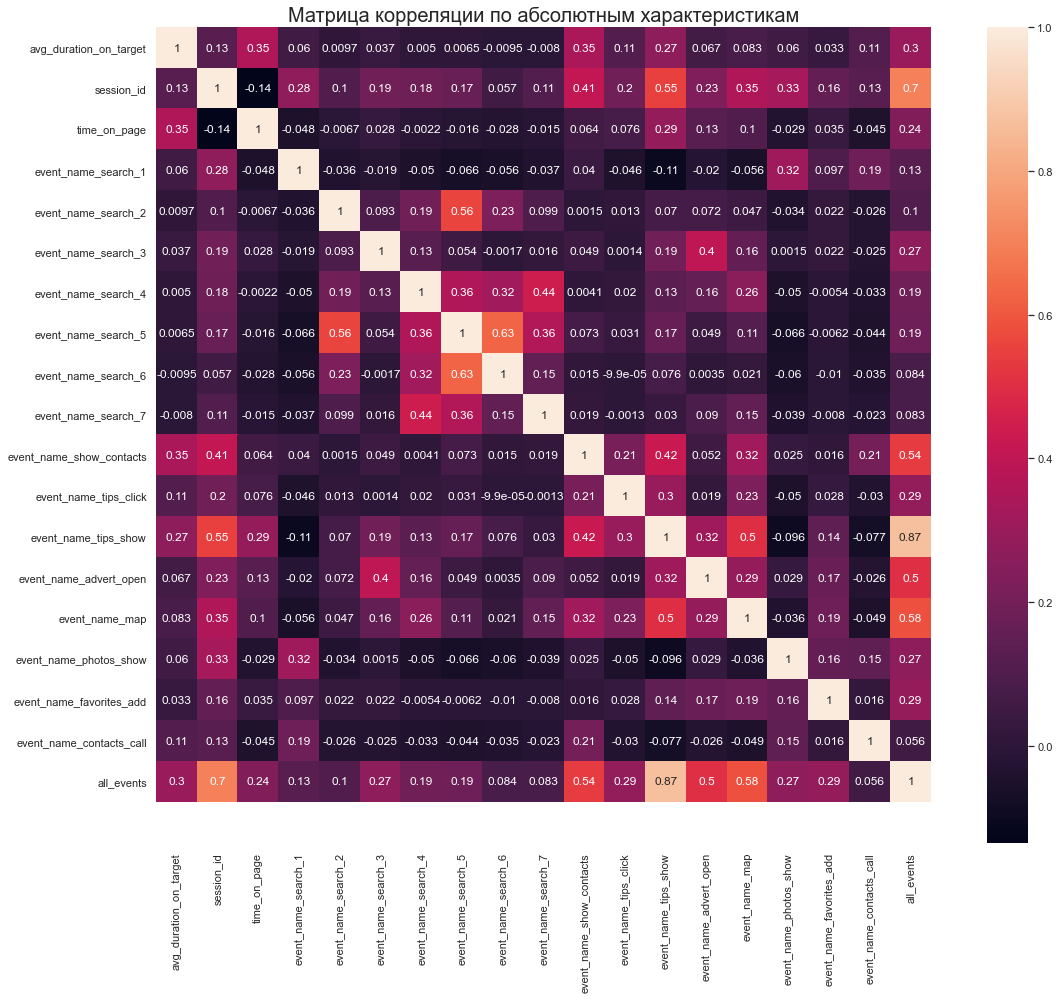

In [234]:
#построим и отрисуем матрицу корреляций
cm = characteristic_users.drop(['user_id','source_google','source_other','source_yandex'],axis=1).corr() #вычисляем матрицу корреляций методом .corr()
fig, ax = plt.subplots(figsize=(20,15))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm,annot = True, square=True) 
ax.set_ylim(20, 0) #корректировка "рваных" полей heatmap в последней версии библиотеки
plt.title('Матрица корреляции по абсолютным характеристикам', fontsize=20)
plt.show()

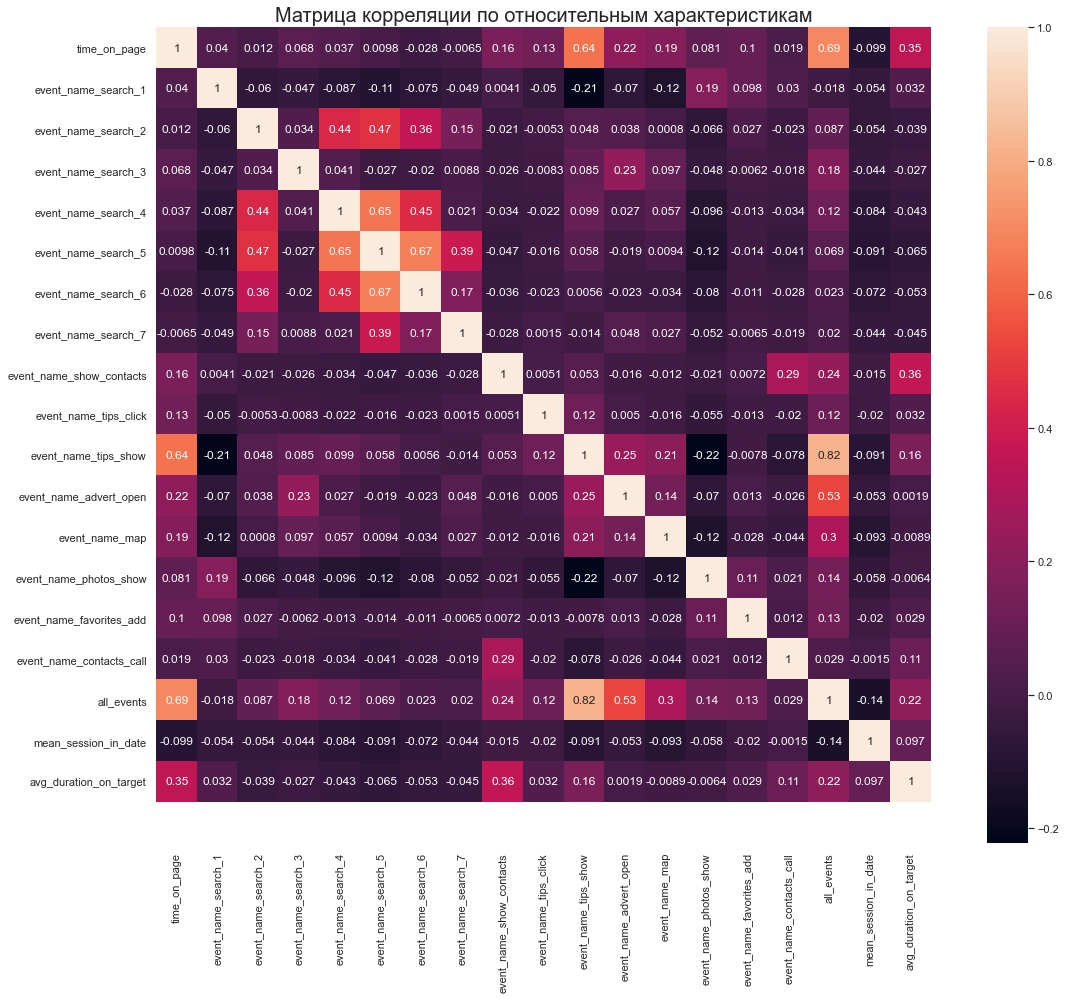

In [273]:
#построим и отрисуем матрицу корреляций
cm = characteristic_users_new.drop(['user_id','source_google','source_other','source_yandex'],axis=1).corr() #вычисляем матрицу корреляций методом .corr()
fig, ax = plt.subplots(figsize=(20,15))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm,annot = True, square=True) 
ax.set_ylim(20, 0) #корректировка "рваных" полей heatmap в последней версии библиотеки
plt.title('Матрица корреляции по относительным характеристикам', fontsize=20)
plt.show()

Как мы видим связи схожих колонок в обсолютных и относительных величинах разные, и примечательно, что сильнее связи в абсолютных характеритиках.

- **Построение дендрограммы**

Для того,чтобы применить метод кластеризации, нужно знать оптимальное число кластеров, на которые мы хотим поделить наших пользователей. С этой задачей нам поможет дендрограмма.

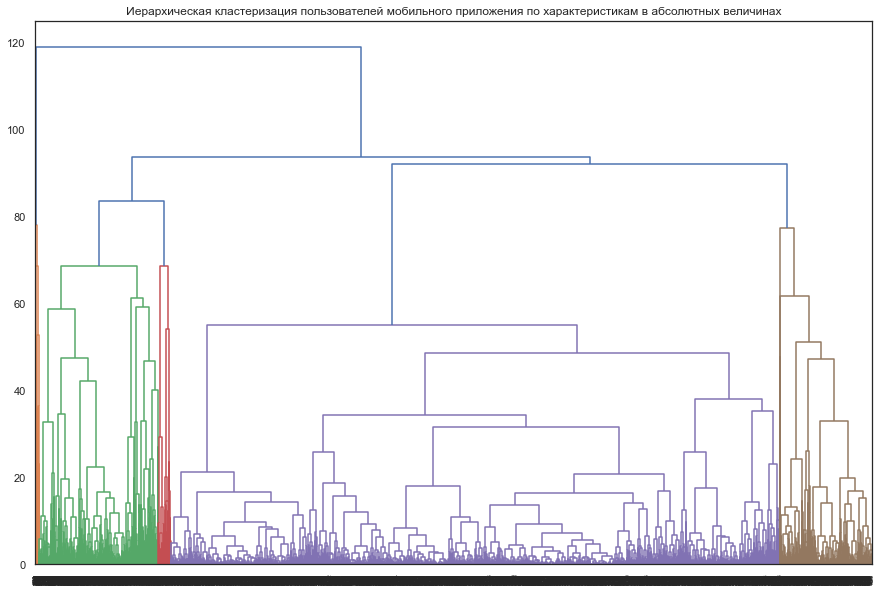

In [242]:
# разделим наши данные на признаки (матрица X) 
X = characteristic_users.drop(['user_id','source_google','source_other','source_yandex'],axis=1)
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
x_st = scaler.fit_transform(X) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
#Теперь построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 
linked = linkage(x_st, method = 'ward')
#В переменной linked сохранена таблица «связок» между объектами. Визуализируем её, как дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей мобильного приложения по характеристикам в абсолютных величинах')
plt.show()

Предложенное оптимальное число кластеров 5 — пять разных цветов на дендограмме, но есть два кластера,которые достаточно маленькие по сравнению с другими тремя, поэтому их можно попытаться объединить в один с уже созданным,а один большой разбить на 2 части поменьше,а следовательно для алгоритма K-means будем использовать 4 кластера.

Проделаем аналогичные шаги для датафрейма с характеристиками в относительных величинах и выясним, сколько для него нужно кластеров нам создать.

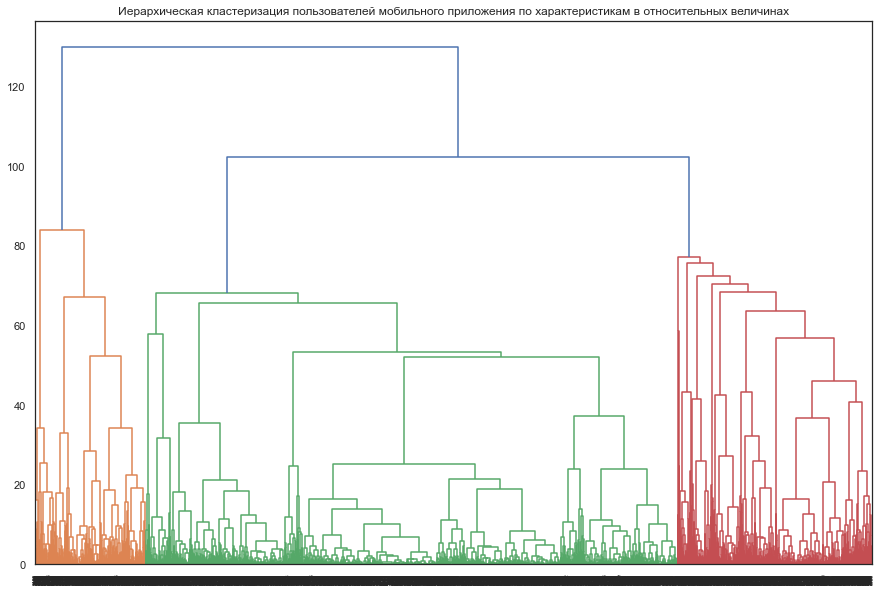

In [274]:
# разделим наши данные на признаки (матрица X) 
X_new = characteristic_users_new.drop(['user_id','source_google','source_other','source_yandex'],axis=1)
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
x_s_new = scaler.fit_transform(X_new) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
#Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 
linked = linkage(x_s_new, method = 'ward')
#В переменной linked сохранена таблица «связок» между объектами. Визуализируем её, как дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей мобильного приложения по характеристикам в относительных величинах')
plt.show()

Алгоритм выдаёт всего 3 кластера, однако второй кластер достаточно большой, поэтому для алгоритма K-means зададим 4 кластера вместо трёх.

- Кластеризация методом K-means

Для начало кластеризуем пользователей на основе характеристик в абсолютных величинах.

In [243]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_st)
# присваиваем значение кластеров пользователям
characteristic_users['cluster_km'] = labels

Исследуем признаки кластеров. 

In [244]:
# выводим статистику по средним значениям наших признаков по кластеру
print(characteristic_users.drop('user_id',axis=1).groupby(['cluster_km']).mean())

            source_google  source_yandex  source_other  \
cluster_km                                               
0                0.354839       0.387097      0.258065   
1                0.247619       0.464286      0.288095   
2                0.262120       0.450453      0.287427   
3                0.307692       0.461538      0.230769   

            avg_duration_on_target  session_id  time_on_page  \
cluster_km                                                     
0                       858.497019    9.956989    622.769347   
1                      1215.028865    4.283333   2018.884423   
2                       123.797017    1.860149    666.830447   
3                      1656.687039   25.384615   1143.759390   

            event_name_search_1  event_name_search_2  event_name_search_3  \
cluster_km                                                                  
0                      9.623656             0.000000             0.000000   
1                      0.064286    

Получили четыре различных кластера, где :

 - `0 кластер` - данный кластер имеет почти равные доли источников яндекс и гугл, длительность сессии в среднем имеет наименьшее значение 620 секунд, при том средняя длительность сесии в целовое действие составляет 860 секунд, что означает, что люди данной группы, когда собираются покупать начинают тормозить и думать,стоит ли им это делать. Данные пользователи совершают достаточно большое число сессий и связаны они с поиском 1 группы предметов, и не смотрят остальные группы, они никогда не кликают по рекомндованным объявлениям,больше всех просмотривают фотографии, много смотрят контакты и больше всех отклюикаются и звонят;
    
  - `1 кластер` - пользователи преобладают с источником яндекс и примерно равнфми долями из других источников и гугла,их сессии связанные с целевым действием в среднем занимают чуть больше 2минут, в то время как общая длителность сессии составляет 2018 секунд, что говорит о то что это люди, которые знаю чего хотят, когда приходят на сайт за нужной им вещью и не медлят в действии. В среднем они совершают небольшое число действий в каждой группе поисков, хотя есть не большие лидеры с 4 и 5 группой поисков. Они видят рекомендованные объявления, но редко кликают по ним, почти не просмаривают фотографии, но порой заходят в просмотр контактов, но не делают звонок;
    
   - `2 кластер` - также смешанная группа по источнику прихода, но её выделяет самая короткая длительность сессий с целевым действием  и в 5 раз большей длительностью среднего времени сессии. Люди такой категории мало совершают действий, и в следствие этого меньше всех что-либо ищат.Они больше всех  смотрят карточки объявлений и редко смотрят фотографии, но остальные действия почти не совершают;
    
   - `3 кластер` - пользователи с большей долей иточников гугл или яндекс,имеют больше двух минут длительность сессии, включающую целевое дествие, которая больше средней длительности сесси, но при этом люди совершают больше всех сессий, они часто заходят в приложение, больше всех находятся в поисках различных групп(1 и 3 к примеру), они больше всего открывают объявления и смотрят карточки, иногда смотрят фотографии, просматривают карты и смотрят контакты, но они никтогда не звонят.
   
У нас есть четкие 4 группы, которые отличаются блительностью и дествиями, всё отлично. Но перед тем, как пристуить к проверке сегментации, найдём группы разделенные по характеристикам в относительных величинах.

In [275]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(x_s_new)
# присваиваем значение кластеров пользователям
characteristic_users_new['cluster_km'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
print(characteristic_users_new.drop('user_id',axis=1).groupby(['cluster_km']).mean())

            time_on_page  source_google  source_other  source_yandex  \
cluster_km                                                             
0             543.506053       0.260616      0.275851       0.463533   
1            1113.118642       0.379391      0.161593       0.459016   
2            2751.460193       0.233236      0.244898       0.521866   
3             713.752839       0.189498      0.515982       0.294521   

            event_name_search_1  event_name_search_2  event_name_search_3  \
cluster_km                                                                  
0                      0.142464             0.001297             0.049271   
1                      2.360656             0.000000             0.007026   
2                      0.000000             0.027697             0.259475   
3                      0.006849             0.345890             0.049087   

            event_name_search_4  event_name_search_5  event_name_search_6  \
cluster_km                 

Также есть различия между группами, но они не на столько различны, как группы делящие людей по общим характеристикам.

## 4. Проверка сегментации пользователей на основе метрик<a id='segment'></a>

In [284]:
#подтягиваем к таблице сессий юзеров кластеры юзеров, чтобы рассчитвать метрики по группам пользователей
sessions_users_=(sessions_users.merge(characteristic_users[['user_id','cluster_km']], on='user_id')
                .merge(mobile_sources,on='user_id')
                .drop(['source_google','source_other','source_yandex'],axis=1))
sessions_users_

,user_id,date,session_id,time_on_page,event_name_search_1,event_name_search_2,event_name_search_3,event_name_search_4,event_name_search_5,event_name_search_6,...,event_name_tips_click,event_name_tips_show,event_name_advert_open,event_name_map,event_name_photos_show,event_name_favorites_add,event_name_contacts_call,all_events,cluster_km,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,805,595.727258,0,0,0,0,0,0,...,0,9,0,0,0,0,0,9,2,other
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,6541,507.385985,0,0,0,0,0,0,...,0,2,0,2,0,0,0,4,2,other
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,36412,899.272096,0,0,0,0,0,0,...,0,12,0,2,0,0,0,14,2,other
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,37556,758.171767,0,0,0,0,0,0,...,0,6,0,2,0,0,0,8,2,other
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,31632,1520.787329,4,0,0,0,0,0,...,0,0,0,0,5,0,0,9,0,yandex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10417,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,69525,0.000000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,3,google
10418,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,70585,974.291817,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2,3,google
10419,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,70771,296.677281,0,0,0,0,0,0,...,0,3,0,0,0,0,0,4,3,google
10420,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,72321,948.307055,0,0,0,0,0,0,...,0,10,0,0,0,0,0,15,3,google


### Retention rate<a id='Retention'></a>

In [285]:
#Сгруппируем данные по столбцу 'user_id' методом groupby().
#Для каждого клиента получим дату первого посещения— ['date'].min()
first_visits_date = sessions_users_.groupby('user_id')['date'].min()
#Чтобы в датафрейме не было двух столбцов с одинаковыми названиями, изменим имя на first_visits_date, обратившись к name Series.
first_visits_date.name = 'first_visits_date'
#Методом join() объединим датафрейм sessions_users и Series first_visits_date по столбцу 'user_id'
cogort= sessions_users_.join(first_visits_date,on='user_id')
#Выделим из столбцов first_visits_date и 'session_date' недели.Вызовем astype(): преобразуем столбцы к типу 'datetime64[w]'. 
cogort['first_visits_week']=cogort['first_visits_date'].astype('datetime64[W]')
cogort['visits_week'] = cogort['date'].astype('datetime64[W]')
cogort['cohort_lifetime'] = (
    (cogort['visits_week'] - cogort['first_visits_week'])
    /np.timedelta64(1,'W')
).round().astype('int')

Когортой делаем столбец кластеров. Рассчитаем количество уникальных посетителей по каждой неделе в зависимости от когорты и времени жизни. Далее расчитываем коэффициент удержания за счет отношения числа пользователей к общему числу(когда 0 неделя жизни), а после убирать из тепловой карты первый столбец, собираем сводную таблицу и создаём тепловую карту.

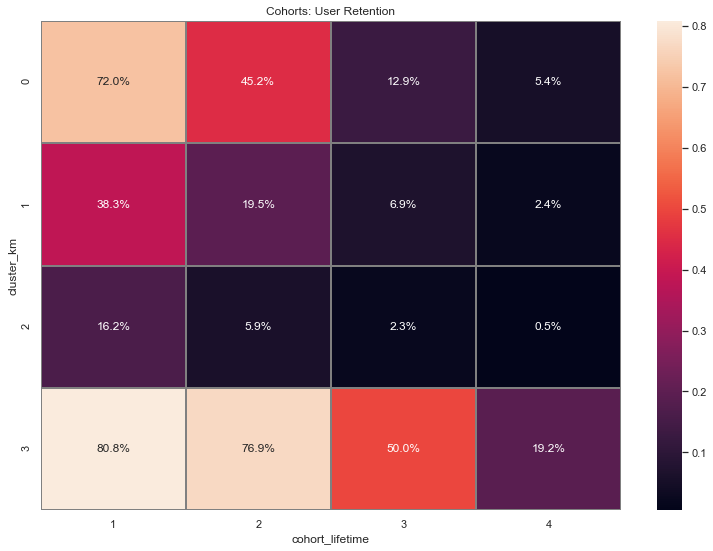

In [286]:
#сделаем аналогичные рассчеты с RR, только теперь когорты будут-источники 
cohorts_for_cluster_km=cogort.groupby(['cluster_km','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
users_count_for_cluster_km=cohorts_for_cluster_km[cohorts_for_cluster_km['cohort_lifetime']==0][['cluster_km', 'user_id']]
users_count_for_cluster_km=users_count_for_cluster_km.rename(columns={'user_id':'cohort_users'})
cohorts_for_cluster_km=cohorts_for_cluster_km.merge(users_count_for_cluster_km, on='cluster_km')
cohorts_for_cluster_km['retention']=cohorts_for_cluster_km['user_id']/cohorts_for_cluster_km['cohort_users']
retention_pivot=cohorts_for_cluster_km[cohorts_for_cluster_km['cohort_lifetime'] !=0].pivot_table(index='cluster_km'
                                                                                          ,columns='cohort_lifetime'
                                                                                          ,values='retention'
                                                                                          ,aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Что и следовало ожидать, между группами видна разница. Пользователи кластера под номерам 3 имеют выше коэффицент удеражания, чем остальные группы, так как они много смотрят объявления объявление и часто сидят в приложении, хотя и не звонят никому, так же достаточно не плохой коэффициент удержания для группы пользователей из кластера 0, для тех кто звонят больше всего, но долго решаются к целевому действию. Похуже ситуация для кластера 1, и самая плохая ситуация с 2 разница, в котором люди в принципе мало совершают действий и имеют самые короткие по длительности сессии в целевое действие.

### Длительность сеанса<a id='duration_session'></a>

Теперь посчитаем длительность сеансов для каждой группы.

In [311]:
sessions_users_.groupby('cluster_km')['time_on_page'].median()

cluster_km
0    200.602906
1    693.798527
2    296.820170
3    436.220936
Name: time_on_page, dtype: float64

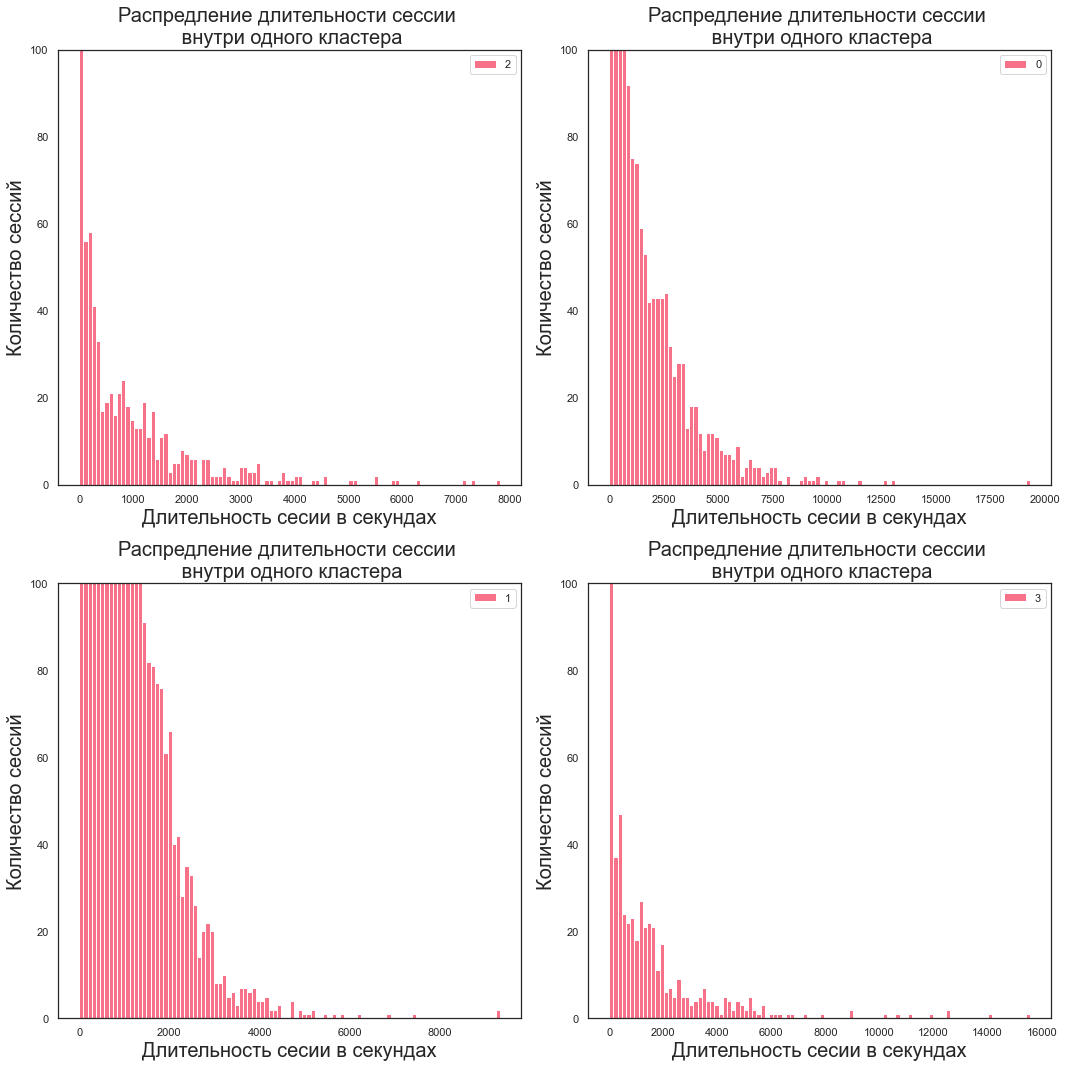

In [312]:
plt.figure(figsize=(15, 15))
for i,cluster in enumerate(sessions_users_['cluster_km'].unique()):
    plt.subplot(2,2,i+1)
    plt.hist(sessions_users_.query('cluster_km==@i')['time_on_page'],bins=100, label=cluster)
    plt.legend()
    plt.title('Распредление длительности сессии \n внутри одного кластера', fontsize=20)
    plt.xlabel('Длительность сесии в секундах', fontsize=20)
    plt.ylabel('Количество сессий', fontsize=20)
    #plt.xlim(xmin=0,xmax=600)
    plt.ylim(ymin=0,ymax=100)
plt.tight_layout()    
plt.show()

Средняя длительность сессии самая мленькая оказалась для группы 2, которые и действуют хуже всех, а самая большая для 0, которые только что и делают, что смотрят фотографии. И не смотря на то что коэффициент удержания для группы 3 был выше и они совершают больше всех действий, самое широкое распределение имее группы 1.

### Частота действий<a id='frequency'></a>

In [290]:
session_events=sessions_users_.groupby('cluster_km').agg({'event_name_search_1':'sum'
                     ,'event_name_search_2':'sum'
                     ,'event_name_search_3':'sum'
                     ,'event_name_search_4':'sum'
                     ,'event_name_search_5':'sum'
                     ,'event_name_search_6':'sum'
                        ,'event_name_search_7':'sum'
                     ,'event_name_show_contacts':'sum'
                     ,'event_name_tips_click':'sum'
                    ,'event_name_tips_show':'sum'
                     ,'event_name_advert_open':'sum'
                     ,'event_name_map':'sum'
                     ,'event_name_photos_show':'sum'
                     ,'event_name_favorites_add':'sum'
                   ,'event_name_contacts_call':'sum'}).transpose()
clusters=session_events.columns
all_event_cluster=[]
for i in clusters:
    all_event_cluster.append(session_events[i].sum())
    all_event=session_events[i].sum()
    session_events['friquence'+str(i)] = session_events[i]/all_event
    
session_events.drop([0,1,2,3],axis=1,inplace=True)    
session_events

cluster_km,friquence0,friquence1,friquence2,friquence3
event_name_search_1,0.171259,0.001199,0.064712,0.004424
event_name_search_2,0.000000,0.006930,0.004081,0.000999
event_name_search_3,0.000000,0.008529,0.006109,0.012702
event_name_search_4,0.000000,0.011816,0.008846,0.012273
event_name_search_5,0.000191,0.018257,0.014600,0.008706
event_name_search_6,0.000000,0.009062,0.006261,0.001284
event_name_search_7,0.000000,0.003865,0.002991,0.002426
event_name_show_contacts,0.091466,0.059879,0.047982,0.115599
event_name_tips_click,0.000000,0.016835,0.009404,0.009134
event_name_tips_show,0.003444,0.673996,0.524207,0.596974


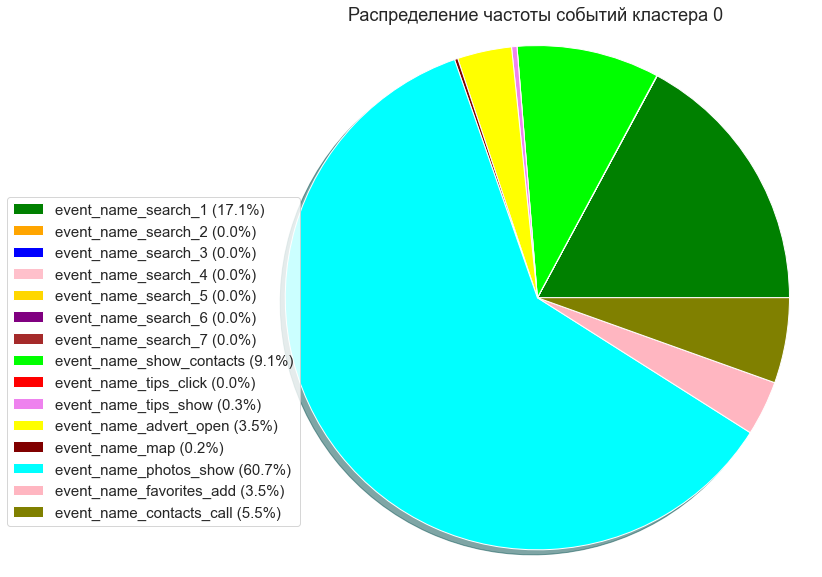

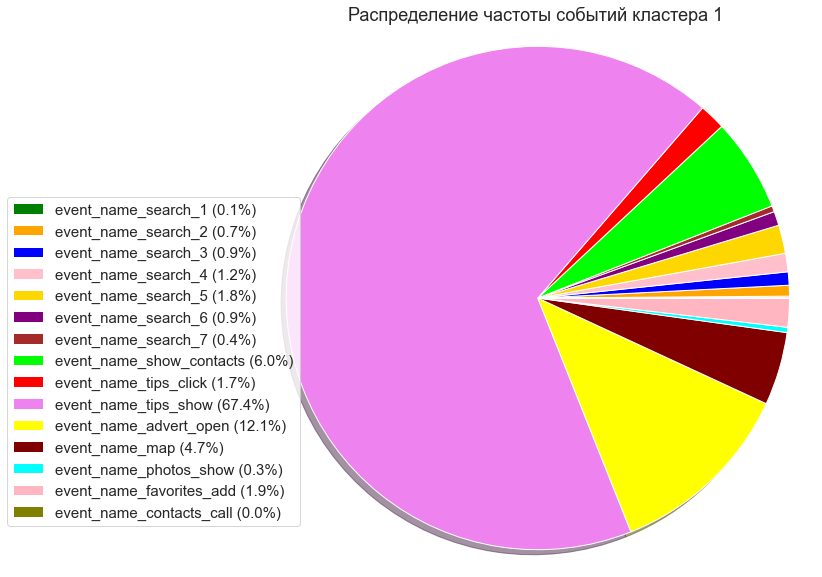

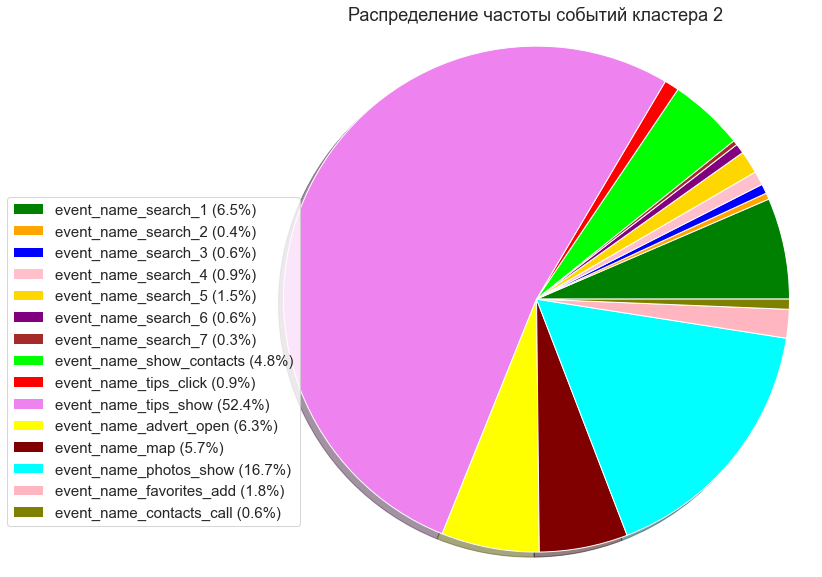

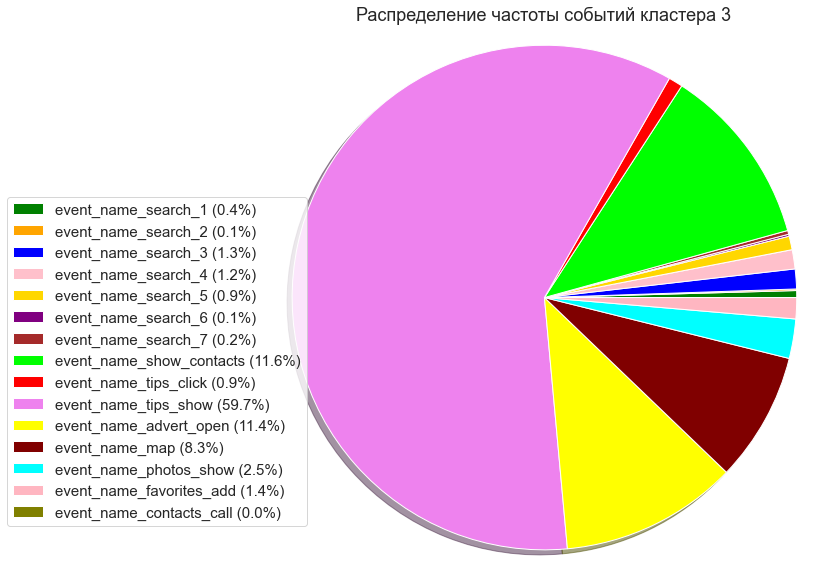

In [336]:
sns.set_palette ("husl")
for i,col in enumerate(session_events.columns):
    plt.subplots(figsize=(10,10))
    total = sum(session_events[col])
    labels = [f"{n} ({v/total:.1%})" for n,v in zip(session_events.index, session_events[col])]
    plt.pie(session_events[col],shadow=True,colors=['green','orange','blue','pink','gold','purple','brown','lime',
                                                                                                    'red','violet','yellow',
                                                                                                    'maroon','cyan','lightpink',
                                                                                                    'olive'])
    plt.axis("equal")    
    plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'best', labels = labels, fontsize=15 )
    plt.title('Распределение частоты событий кластера '+str(i), fontsize=18)


Пользователи группы 0 ищут предметы только первой группы и больше всех просматриваю фото, контакты и звонят.
Пользователи группы 1 больше всех карточки объявлений открывают и видят рекомендованные объявлений и добавляют в рекомендованные.
Пользователи группы 3 открывают карты, просматривают контакты и никогда не звонят.

### Конверсия в просмотры контактов<a id='conversion'></a>

Ранее уже было получео распределение долей пользователей по событиям, которое было сохранено в event_users. На основе этих данных составим простую воронку событий:tips_show,map, и show_contacts и по ней рассчитаем конверсию переходов.

In [306]:
#сгруппируем данные по событиям и для каждого из них посчитаем число уникальных пользователей
event_users_cluster=(data[data['event_name'].isin(['tips_show','map','show_contacts'])]
                     .merge(characteristic_users_new[['user_id','cluster_km']], on='user_id')
                     .groupby(['cluster_km','event_name'], as_index=False)
                     .agg({'user_id':'nunique'})
                     .rename(columns={'user_id':'count_users'})
                     .sort_values(['cluster_km','count_users'],ascending=False)
                     .reset_index(drop=True)
            )
event_users_cluster

,cluster_km,event_name,count_users
0,3,tips_show,380
1,3,map,157
2,3,show_contacts,36
3,2,tips_show,338
4,2,map,209
5,2,show_contacts,100
6,1,show_contacts,99
7,1,tips_show,3
8,1,map,1
9,0,tips_show,2080


Видно что в группе 1 последовательность действий иная, чем для остальных для трёх групп, но при этом конверсия в 3 группе равна 36/157=0,23;в 2 группе почти100/209=0,48 и в 0 группе746/1089= 0,68. Вторая группа выше по конверсии, так как там в принципе пользователи редко заходят в приложение, то есть идут они точно за конкретным действием, а в 0 выше чем в 3 и больше всех, так как они нацеленнно ишут лишь 1 группу и долго принимают решение и взвешенно следовательно, а 3 просто любят смотреть, кликать, но никогда не звонят.

#### Вывод

Кластеризация проведена успешна, удержание выше всего в той группе, кто больше всего совершает действий,как и звонит и заказывает что-то, а меньше всего в той что заходят в приложение. Конверсия и длительность выше в той группе,что опять же приходят к покупке и и для тех, кто заходят в приложение с конкретной целью

## 5. Проверка гипотез<a id='suggests'></a>

### Проверка первой гипотезы<a id='first'></a>

Так как некоторые пользователи установили приложение по ссылке из yandex,а другие — из google, то наши гипотезы выглядят следующим образом: 

- H0 гипотеза: пользователи пришедшие из источников yandex и google демонстрируют одинаковую конверсию в просмотры контактов;
- H1 гипотеза: пользователи пришедшие из источников yandex и google имеют различия в конверсии в просмотры контактов.

Так как конверсия - доли(отношения), то статистическую разницу будем искать z-критерием для долей. Для этого создаём функцию для рассчёта уровня статистической значимости.

In [164]:
def function(A, B,A_total, B_total, alpha):
       
    # пропорция успехов в первой группе:
    p1 = A/A_total

    # пропорция успехов во второй группе:
    p2 = B/B_total
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (A + B)/ (A_total + B_total)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/A_total + 1/B_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value.round(2))

    if (p_value < alpha):
        return ("Отвергаем нулевую гипотезу: между конверсиями есть значимая разница")
    else:
        return ("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсиями разными")  

Цепочку создаём как: 'tips_show'-'map'-'photos_show'-'show_contacts' на основе общей доли пользователей по видам событий. Поэтому создадим хронологическую цепочку по данному порядку действий.

In [151]:
#создадим сводную таблицу users , где индекс- айди пользователя, столбцы - события, а значение- первое время совершения события
users =(data
        .pivot_table(
            index=['user_id', 'source'],
            columns='event_name', 
            values='event_time',
            aggfunc='min')
        .reset_index()
       )
users.head()

event_name,user_id,source,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,show_contacts,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,NaT,NaT,NaT,2019-10-09 18:33:55.577963,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-10-07 13:39:45.989359
1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-24 10:52:18.644065,2019-10-20 19:17:24.887762,2019-10-20 19:03:02.030004,NaT,2019-10-19 21:40:38.990477,2019-10-19 21:34:33.849769,NaT,NaT,NaT,NaT,NaT,NaT,2019-10-20 19:17:18.659799,NaT,NaT
2,00463033-5717-4bf1-91b4-09183923b9df,yandex,NaT,NaT,NaT,NaT,2019-11-01 13:54:35.385028,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-27 00:08:28.225172,NaT,NaT,2019-10-18 22:17:40.719687,NaT,NaT,NaT,2019-10-31 21:42:15.606558,2019-10-20 17:47:19.889629,2019-10-18 22:14:16.960831,2019-10-20 17:47:38.353167,2019-10-18 22:14:05.555052,NaT,NaT,2019-10-20 17:48:42.169252
4,00551e79-152e-4441-9cf7-565d7eb04090,yandex,NaT,2019-10-25 16:44:44.786860,NaT,NaT,2019-10-29 02:17:12.342406,2019-10-28 13:08:15.809056,NaT,NaT,NaT,NaT,NaT,NaT,2019-10-25 16:44:41.263364,NaT,NaT


In [160]:
def fulle(df:pd.DataFrame):
    step_1 = ~df['tips_show'].isna()
    step_2 = step_1 & (df['map'] >= df['tips_show'])
    step_3 = step_2 & (df['show_contacts'] >= df['map'])
    #step_4 = step_3 & (df['show_contacts'] >= df['photos_show'])

    #фильтруем данные users  и методом .shape[0] определяем число пользователей
    n_tips_show=df[step_1].shape[0]
    n_map = df[step_2].shape[0]
    #n_photos_show = df[step_3].shape[0]
    n_show_contacts = df[step_3].shape[0]
    #возвращаем список пользователей воронки событий
    return [n_tips_show,n_map,n_show_contacts]

In [161]:
#количество юзеров для воронки в группе google
users_google_for_events=fulle(users.query('source=="google"').reset_index(drop=True))
users_google_for_events

[651, 105, 15]

In [162]:
#количество юзеров для воронки в группе yandex
users_yandex_for_events=fulle(users.query('source=="yandex"').reset_index(drop=True))
users_yandex_for_events

[1310, 191, 27]

In [165]:
alpha = .05 # критический уровень статистической значимости
#создаём цикл по прохождению каждого события
answer=function(users_google_for_events[-1]
         ,users_yandex_for_events[-1]
         ,users_google_for_events[-2]
         ,users_yandex_for_events[-2]
         ,alpha)
#сохраняем ответ в колонку 'result_test'    
print(answer)  

p-значение:  0.97
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсиями разными


### Проверка второй гипотезы<a id='second'></a>

Мы знаем, что не все пользователи приходят из известных источников, таких как yandex или google, поэтому нашими гипотезами будут следующие высказывания:

- H0: Частота действие пользователей не зависит от того из какого источника пришел пользователь;
- H1: Пользователи, пришедшие из известных источников, имеют отличную частоту действий, чем пользователи, пришедшие из каких либо-других источников.

События - отдельные метрики для одних и тех же двух групп, поэтому понижать критический уровень значимости не надо в статистических тестах.

In [183]:
#получаем частоту действий для пользователей с истоником other
other_events=(data.query('source=="other"')
              .groupby('event_name')
              .agg({'event_time':'count'})
              .rename(columns={'event_time':'cnt_other'})
              .sort_values('cnt_other',ascending=False)
              .reset_index()
             )
all_other_events=other_events['cnt_other'].sum()
other_events

,event_name,cnt_other
0,tips_show,10125
1,photos_show,2862
2,advert_open,1918
3,show_contacts,1054
4,map,910
5,search_1,499
6,search_5,489
7,search_4,291
8,favorites_add,259
9,tips_click,228


In [182]:
#получаем частоту действий для пользователей с истониками google и yandex
popular_events=(data.query('source==("google","yandex")')
              .groupby('event_name')
              .agg({'event_time':'count'})
              .rename(columns={'event_time':'cnt_popular'})
              .sort_values('cnt_popular',ascending=False)
                .reset_index()
             )
all_popular_events=popular_events['cnt_popular'].sum()
popular_events

,event_name,cnt_popular
0,tips_show,29930
1,photos_show,7150
2,advert_open,4246
3,show_contacts,3475
4,search_1,3007
5,map,2971
6,favorites_add,1158
7,tips_click,586
8,search_5,560
9,search_4,410


In [208]:
def function_2(A, B,A_total, B_total, alpha):
       
    # пропорция успехов в первой группе:
    p1 = A/A_total

    # пропорция успехов во второй группе:
    p2 = B/B_total
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (A + B)/ (A_total + B_total)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/A_total + 1/B_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if (p_value < alpha):
        return ("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        return ("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  

In [211]:
#сохраняем ответ в список answer
answer=[]
alpha = .05 # критический уровень статистической значимости
#создаём цикл по прохождению каждого события
for event in popular_events['event_name'].unique():
    answer.append(function_2(popular_events.query('event_name==@event')['cnt_popular'].values[0]
                           ,other_events.query('event_name==@event')['cnt_other'].values[0]
                           ,all_popular_events
                           ,all_other_events
                           ,alpha))
control_test =  popular_events.merge(other_events,on='event_name')  
control_test['frequenc_popular']=control_test['cnt_popular']/all_popular_events
control_test['frequenc_other']=control_test['cnt_other']/all_other_events
#сохраняем ответ в колонку 'result_test'    
control_test['result_test']=answer    
control_test    

,event_name,cnt_popular,cnt_other,frequenc_popular,frequenc_other,result_test
0,tips_show,29930,10125,0.546856,0.520138,Отвергаем нулевую гипотезу: между долями есть ...
1,photos_show,7150,2862,0.130639,0.147026,Отвергаем нулевую гипотезу: между долями есть ...
2,advert_open,4246,1918,0.077579,0.098531,Отвергаем нулевую гипотезу: между долями есть ...
3,show_contacts,3475,1054,0.063492,0.054146,Отвергаем нулевую гипотезу: между долями есть ...
4,search_1,3007,499,0.054941,0.025634,Отвергаем нулевую гипотезу: между долями есть ...
5,map,2971,910,0.054284,0.046748,Отвергаем нулевую гипотезу: между долями есть ...
6,favorites_add,1158,259,0.021158,0.013305,Отвергаем нулевую гипотезу: между долями есть ...
7,tips_click,586,228,0.010707,0.011713,"Не получилось отвергнуть нулевую гипотезу, нет..."
8,search_5,560,489,0.010232,0.025121,Отвергаем нулевую гипотезу: между долями есть ...
9,search_4,410,291,0.007491,0.014949,Отвергаем нулевую гипотезу: между долями есть ...


#### Вывод

Первая гипотеза не доказана,что уже было и подтверждено ранее метрикой Retention rate. Ни яндекс, ни гугл не влияют на конверсию в целевое действие.

Вторая гипотеза также не доказана , почти все действия различаются по частоте между пользователями, пришедшими из разных источников, только звонок и клик по рекомендованному объявлению имеют схожие доли между разными типами источников по полярности.

## Общий вывод<a id='conclusion'></a>

Была проведена кластеризация пользователей, на её основании стоит для группы 3 сделать возможно спец предложения, так как они наши самые активные пользователи, и попытаться завлечь больше группу 2, выяснить причину бездействия людей, вллияние внешних факторой.

Источник не влияет на удержание и конверсию в целовое действие, однако пользователи, пришедшие из разных источников, совершают разные действия.